<a href="https://colab.research.google.com/github/AlirezaSM/template-matching/blob/main/template_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [2]:
!git clone https://github.com/cplusx/QATM.git

Cloning into 'QATM'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 9.19 MiB | 32.90 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
!7z x drive/MyDrive/Dataset.7z -o.


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5359681573 bytes (5112 MiB)

Extracting archive: drive/MyDrive/Dataset.7z
--
Path = drive/MyDrive/Dataset.7z
Type = 7z
Physical Size = 5359681573
Headers Size = 279463
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 1        0% 1 - Dataset/Sample0001_Box.txt                                     0% 11 - Dataset/Sample0004_Image.png                                        0% 12 - Dataset/Sample0004_Template.png                                           0% 23 - Dataset/Sam

# Using QATM for template matching

In [4]:
from __future__ import print_function, division

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [6]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar

In [7]:
print(keras.__version__, tf.__version__)

2.9.0 2.9.2


In [8]:
from QATM.models import QATM, MyNormLayer
from QATM.utils import compute_score, all_sample_iou, plot_success_curve

In [17]:
file_dir = 'Dataset'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Image.png' in i ] )
tmp_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Template.png' in i ] )

gt = gt[:100]
img_path = img_path[:100]
tmp_path = tmp_path[:100]


def read_gt( file_path ):
    with open( file_path ) as IN:
        xmin, ymin, xmax, ymax = [ eval(i) for i in IN.readline().strip().split(',')]
        w = xmax - xmin
        h = ymax - ymin
    return xmin, ymin, w, h

In [10]:
import numpy as np
from scipy import signal

In [11]:
tf.config.run_functions_eagerly(True)

In [12]:
from sklearn.preprocessing import MinMaxScaler
def the_corr(x):
    T_feat=np.array(x[0])
    k_feat=np.array(x[1])

#     # T_array = tf.make_ndarray(tf.make_tensor_proto(T_feat))
#     # k_array = tf.make_ndarray(tf.make_tensor_proto(k_feat))
#     T_array=T_feat.numpy()
#     corr = np.zeros_like(T_feat)

    # scaler = MinMaxScaler()
    # for i in range(T_feat.shape[3]):
    #    T_feat[0 ,: ,: ,i] = scaler.fit_transform(signal.correlate2d(T_feat[0 ,: ,: ,i], k_feat[0 ,: ,: ,i], boundary='fill', mode='same'))+0.75
    # T_feat = scaler.fit_transform(T_feat)
    return T_feat

In [13]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 320), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )   
    k = Input( (None, None, 320), name='key_input' )   
    
    T_feat = T
    I_feat = featex(I)

    # T_feat = tf.keras.layers.Multiply()([T_feat, k])
    # corr = np.zeros_like(T_feat)
    # for i in range(T_feat.shape[3]):
    #   corr[0,:,: ,i] = signal.correlate2d(T_feat[0 ,: ,: ,i], k_feat[0 ,: ,: ,i], boundary='symm', mode='same')

    # T_feat= T_feat *corr

    # T_feat = keras.layers.Lambda(the_corr)([T_feat,k_feat])



    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')(dist)
    return Model( [T, I ,k], [conf_map], name='QATM_model' )
    
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    num_samples = len(img_path)
    bar = progressbar.ProgressBar(max_value=num_samples)
    for idx in range(num_samples):
        bar.update(idx + 1)
        # load image and ground truth
        template = cv2.imread( tmp_path[idx] )[...,::-1]
        image = cv2.imread( img_path[idx]) [...,::-1]
        image_gt = read_gt( gt[idx] )
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        w = image.shape[0]
        h = image.shape[1]

        #finding key point        
        candidate_size = (template.shape[0] // 2, template.shape[1] // 2)
        stride_size = (template.shape[0] // 4, template.shape[1] // 4)
        m = np.array([int(np.mean(template[...,0])), int(np.mean(template[...,1])), int(np.mean(template[...,2]))])
        start_point = [0, 0]
        min_value = 0
        min_index = [0, 0]
        for i in range(3):
            start_point[0] = i * stride_size[0]
            for j in range(3):
                start_point[1] = j * stride_size[1]
                candid = template.copy()
                candid[start_point[0]: start_point[0] + candidate_size[0], start_point[1]: start_point[1] + candidate_size[1]] = m
                i_product = sum(candid.reshape(-1)* template.reshape(-1))
                if i == 0 and j == 0:
                    min_value = i_product
                    
                if i_product < min_value:
                    min_value = i_product
                    min_index = [i, j]
        

        start_point[0] = min_index[0] * stride_size[0]
        start_point[1] = min_index[1] * stride_size[1]

        key = template.copy()
        key = key[start_point[0]: start_point[0] + candidate_size[0], start_point[1]: start_point[1] + candidate_size[1]]




        # process images
        key_= np.expand_dims(preprocess_input( key ), axis=0)
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)

        try:
          if w*h < 130000:
            key_=featex(key_)
            template_=backup(template_)
            key_=the_corr([template_,key_])
            val = model.predict( [template_, image_,key_ ] )
          else:
            # used when image is too big
            key_=backup(key_)
            template_=backup(template_)
            key_=the_corr([template_,key_])
            val = model_bkup.predict( [template_, image_,key_] )
        except Exception as e:
          print(f'error index {idx}')
          print(e)
          break
        
        
        # compute geometry mean on score map
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        score = compute_score( gray, w_gt, h_gt )
        
        score[score>-1e-7] = -np.inf
        plt.figure()
        plt.imshow(score)
        plt.show()
        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

In [14]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 280ms/step


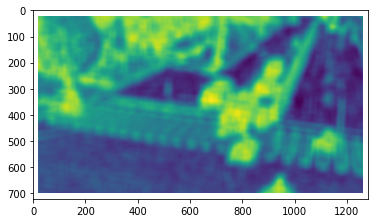

  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:41

1/1 [==============================] - 0s 319ms/step


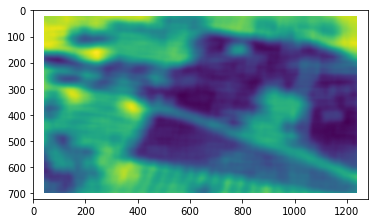

  3% (3 of 100) |                        | Elapsed Time: 0:00:07 ETA:   0:08:17

1/1 [==============================] - 0s 282ms/step


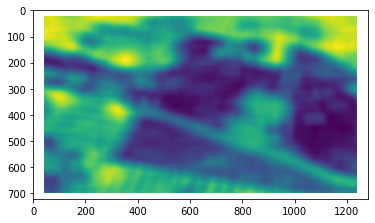

  4% (4 of 100) |                        | Elapsed Time: 0:00:12 ETA:   0:08:00

1/1 [==============================] - 0s 286ms/step


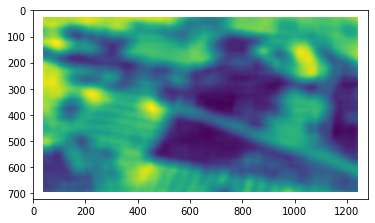

  5% (5 of 100) |#                       | Elapsed Time: 0:00:17 ETA:   0:08:02

1/1 [==============================] - 0s 293ms/step


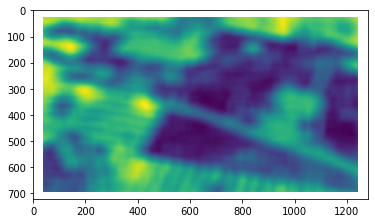

  6% (6 of 100) |#                       | Elapsed Time: 0:00:22 ETA:   0:07:55

1/1 [==============================] - 0s 326ms/step


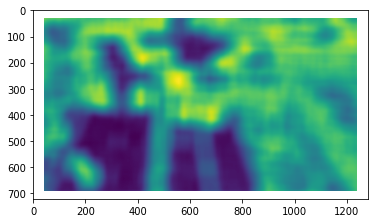

  7% (7 of 100) |#                       | Elapsed Time: 0:00:29 ETA:   0:10:18

1/1 [==============================] - 0s 312ms/step


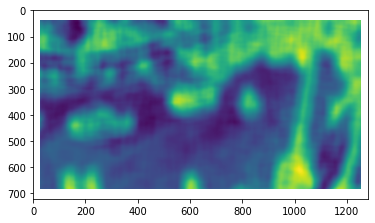

  8% (8 of 100) |#                       | Elapsed Time: 0:00:34 ETA:   0:07:47

1/1 [==============================] - 0s 286ms/step


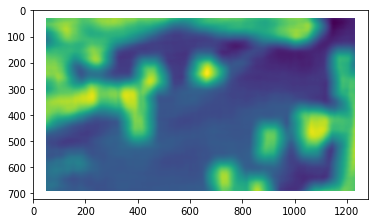

  9% (9 of 100) |##                      | Elapsed Time: 0:00:41 ETA:   0:11:49

1/1 [==============================] - 0s 307ms/step


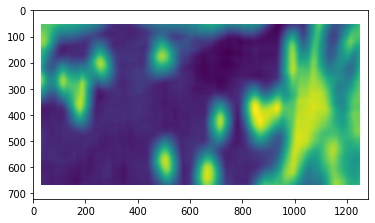

 10% (10 of 100) |##                     | Elapsed Time: 0:00:50 ETA:   0:13:04

1/1 [==============================] - 0s 287ms/step


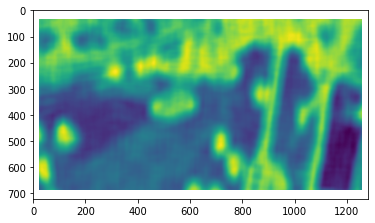

 11% (11 of 100) |##                     | Elapsed Time: 0:00:54 ETA:   0:05:47

1/1 [==============================] - 0s 284ms/step


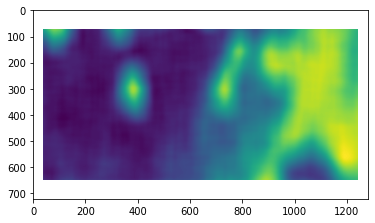

 12% (12 of 100) |##                     | Elapsed Time: 0:01:09 ETA:   0:21:30

1/1 [==============================] - 0s 223ms/step


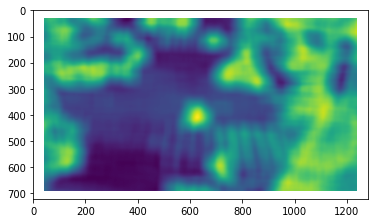

 13% (13 of 100) |##                     | Elapsed Time: 0:01:15 ETA:   0:09:27

1/1 [==============================] - 0s 225ms/step


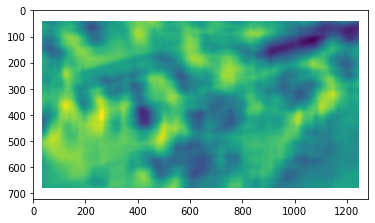

 14% (14 of 100) |###                    | Elapsed Time: 0:01:23 ETA:   0:10:56

1/1 [==============================] - 0s 225ms/step


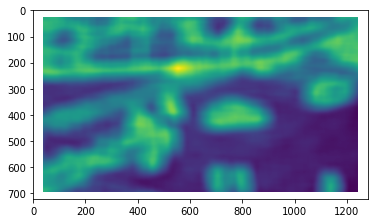

 15% (15 of 100) |###                    | Elapsed Time: 0:01:28 ETA:   0:07:52

1/1 [==============================] - 0s 220ms/step


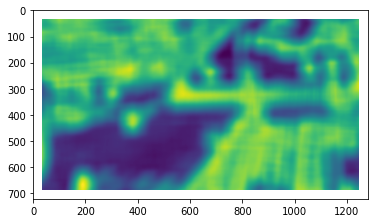

 16% (16 of 100) |###                    | Elapsed Time: 0:01:34 ETA:   0:08:10

1/1 [==============================] - 0s 287ms/step


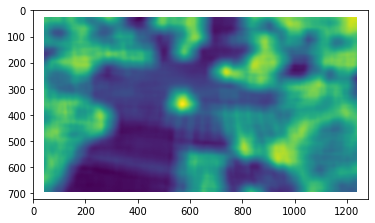

 17% (17 of 100) |###                    | Elapsed Time: 0:01:40 ETA:   0:07:16

1/1 [==============================] - 0s 231ms/step


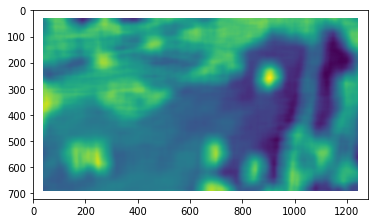

 18% (18 of 100) |####                   | Elapsed Time: 0:01:45 ETA:   0:08:08

1/1 [==============================] - 0s 241ms/step


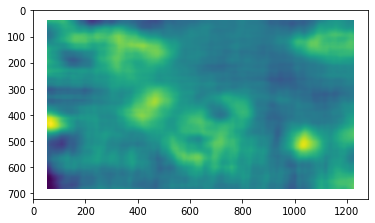

 19% (19 of 100) |####                   | Elapsed Time: 0:01:56 ETA:   0:14:40

1/1 [==============================] - 0s 228ms/step


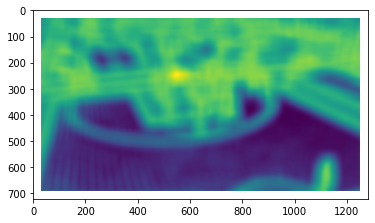

 20% (20 of 100) |####                   | Elapsed Time: 0:02:01 ETA:   0:06:15

1/1 [==============================] - 0s 249ms/step


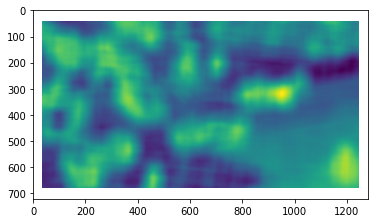

 21% (21 of 100) |####                   | Elapsed Time: 0:02:09 ETA:   0:10:12

1/1 [==============================] - 0s 292ms/step


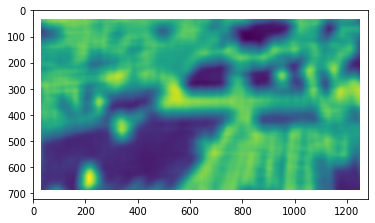

 22% (22 of 100) |#####                  | Elapsed Time: 0:02:14 ETA:   0:06:16

1/1 [==============================] - 0s 254ms/step


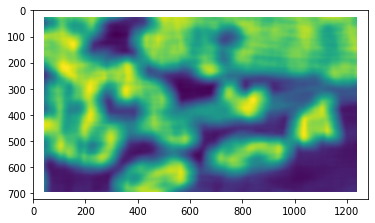

 23% (23 of 100) |#####                  | Elapsed Time: 0:02:19 ETA:   0:06:54

1/1 [==============================] - 0s 231ms/step


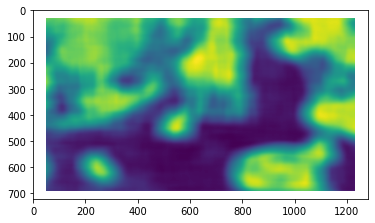

 24% (24 of 100) |#####                  | Elapsed Time: 0:02:27 ETA:   0:09:52

1/1 [==============================] - 0s 286ms/step


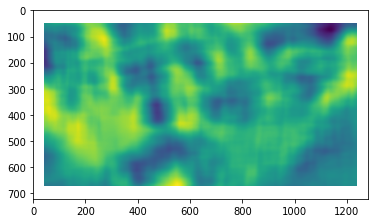

 25% (25 of 100) |#####                  | Elapsed Time: 0:02:38 ETA:   0:14:02

1/1 [==============================] - 0s 238ms/step


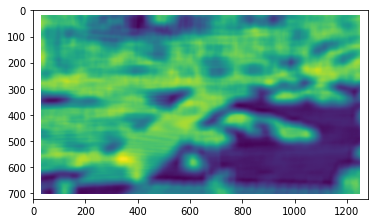

 26% (26 of 100) |#####                  | Elapsed Time: 0:02:41 ETA:   0:04:10

1/1 [==============================] - 0s 235ms/step


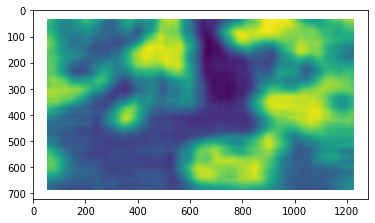

 27% (27 of 100) |######                 | Elapsed Time: 0:02:50 ETA:   0:10:55

1/1 [==============================] - 0s 323ms/step


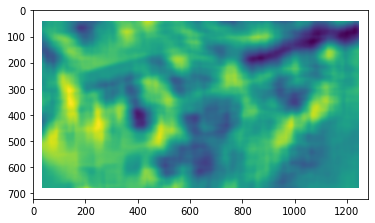

 28% (28 of 100) |######                 | Elapsed Time: 0:02:58 ETA:   0:08:51

1/1 [==============================] - 0s 339ms/step


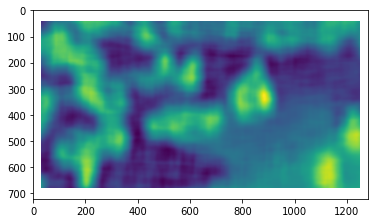

 28% (29 of 100) |######                 | Elapsed Time: 0:03:05 ETA:   0:08:02

1/1 [==============================] - 0s 281ms/step


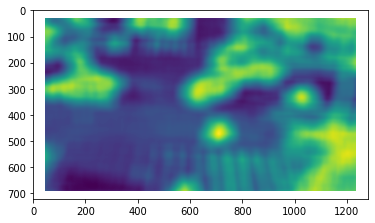

 30% (30 of 100) |######                 | Elapsed Time: 0:03:12 ETA:   0:08:26

1/1 [==============================] - 0s 342ms/step


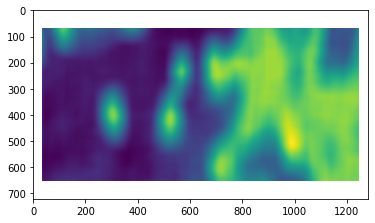

 31% (31 of 100) |#######                | Elapsed Time: 0:03:24 ETA:   0:14:13

1/1 [==============================] - 0s 289ms/step


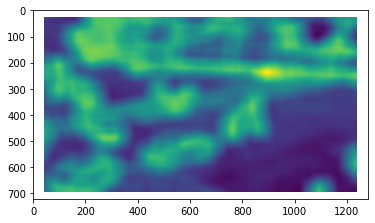

 32% (32 of 100) |#######                | Elapsed Time: 0:03:30 ETA:   0:06:17

1/1 [==============================] - 0s 253ms/step


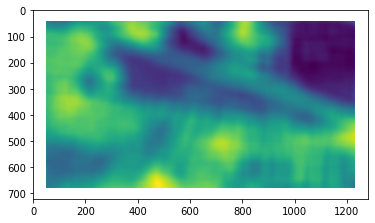

 33% (33 of 100) |#######                | Elapsed Time: 0:03:41 ETA:   0:12:28

1/1 [==============================] - 0s 282ms/step


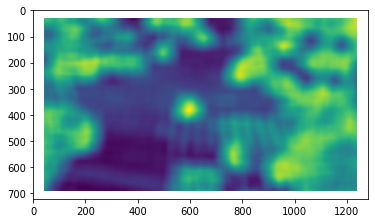

 34% (34 of 100) |#######                | Elapsed Time: 0:03:47 ETA:   0:06:29

1/1 [==============================] - 0s 262ms/step


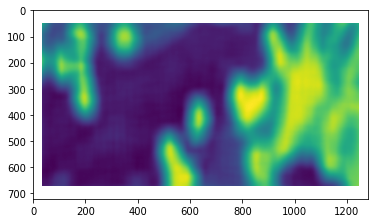

 35% (35 of 100) |########               | Elapsed Time: 0:03:56 ETA:   0:09:50

1/1 [==============================] - 0s 251ms/step


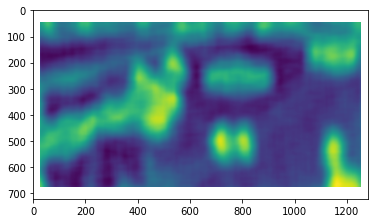

 36% (36 of 100) |########               | Elapsed Time: 0:04:03 ETA:   0:07:22

1/1 [==============================] - 0s 344ms/step


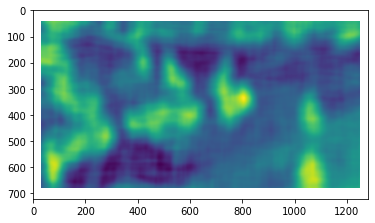

 37% (37 of 100) |########               | Elapsed Time: 0:04:09 ETA:   0:06:56

1/1 [==============================] - 0s 288ms/step


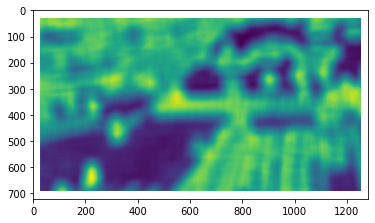

 38% (38 of 100) |########               | Elapsed Time: 0:04:14 ETA:   0:04:36

1/1 [==============================] - 0s 322ms/step


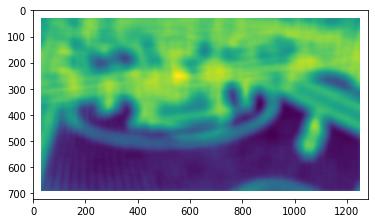

 39% (39 of 100) |########               | Elapsed Time: 0:04:18 ETA:   0:04:31

1/1 [==============================] - 0s 305ms/step


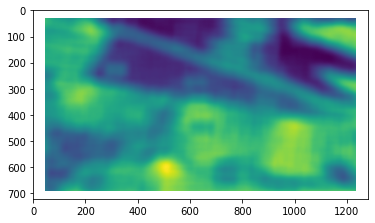

 40% (40 of 100) |#########              | Elapsed Time: 0:04:25 ETA:   0:06:59

1/1 [==============================] - 0s 321ms/step


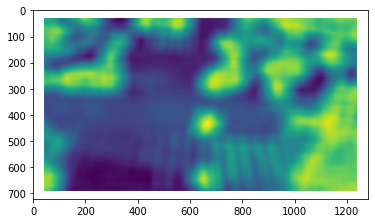

 41% (41 of 100) |#########              | Elapsed Time: 0:04:32 ETA:   0:06:46

1/1 [==============================] - 0s 306ms/step


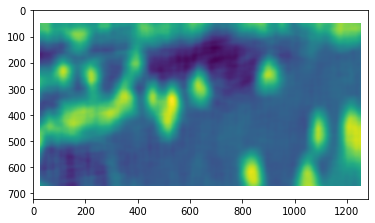

 42% (42 of 100) |#########              | Elapsed Time: 0:04:38 ETA:   0:05:58

1/1 [==============================] - 0s 313ms/step


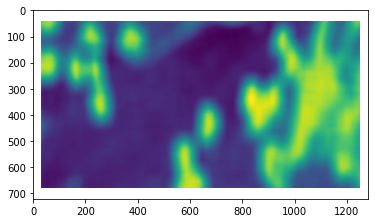

 43% (43 of 100) |#########              | Elapsed Time: 0:04:45 ETA:   0:05:53

1/1 [==============================] - 0s 309ms/step


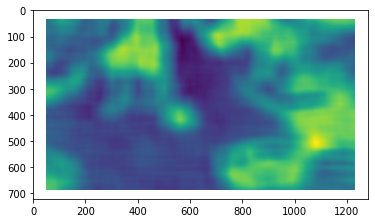

 44% (44 of 100) |##########             | Elapsed Time: 0:04:53 ETA:   0:08:07

1/1 [==============================] - 0s 307ms/step


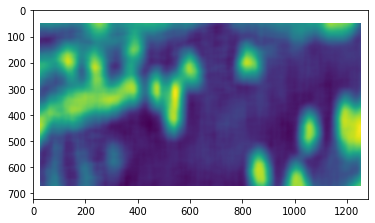

 45% (45 of 100) |##########             | Elapsed Time: 0:05:00 ETA:   0:05:54

1/1 [==============================] - 0s 232ms/step


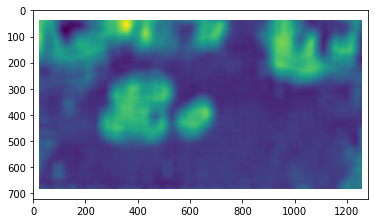

 46% (46 of 100) |##########             | Elapsed Time: 0:05:04 ETA:   0:04:10

1/1 [==============================] - 0s 290ms/step


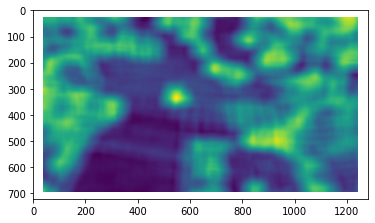

 47% (47 of 100) |##########             | Elapsed Time: 0:05:09 ETA:   0:04:16

1/1 [==============================] - 0s 325ms/step


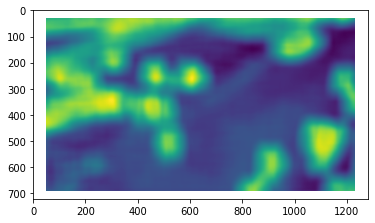

 48% (48 of 100) |###########            | Elapsed Time: 0:05:17 ETA:   0:06:40

1/1 [==============================] - 0s 292ms/step


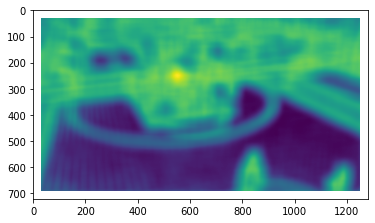

 49% (49 of 100) |###########            | Elapsed Time: 0:05:21 ETA:   0:03:44

1/1 [==============================] - 0s 310ms/step


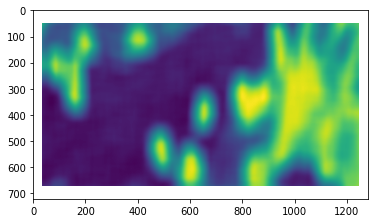

 50% (50 of 100) |###########            | Elapsed Time: 0:05:30 ETA:   0:07:05

1/1 [==============================] - 0s 283ms/step


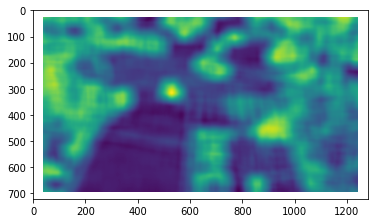

 51% (51 of 100) |###########            | Elapsed Time: 0:05:34 ETA:   0:03:45

1/1 [==============================] - 0s 284ms/step


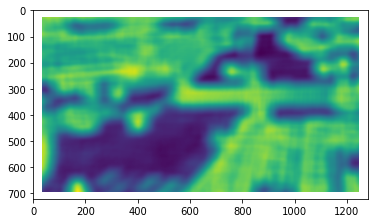

 52% (52 of 100) |###########            | Elapsed Time: 0:05:39 ETA:   0:03:35

1/1 [==============================] - 0s 249ms/step


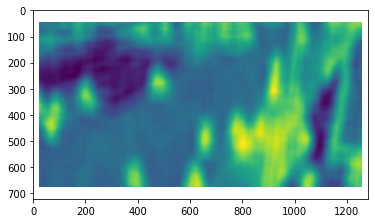

 53% (53 of 100) |############           | Elapsed Time: 0:05:45 ETA:   0:04:33

1/1 [==============================] - 0s 332ms/step


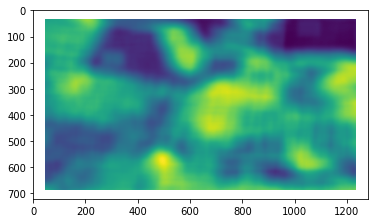

 54% (54 of 100) |############           | Elapsed Time: 0:05:53 ETA:   0:06:14

1/1 [==============================] - 0s 292ms/step


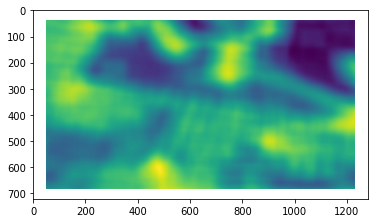

 55% (55 of 100) |############           | Elapsed Time: 0:06:02 ETA:   0:06:57

1/1 [==============================] - 0s 340ms/step


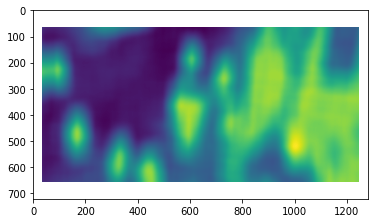

 56% (56 of 100) |############           | Elapsed Time: 0:06:14 ETA:   0:08:46

1/1 [==============================] - 0s 225ms/step


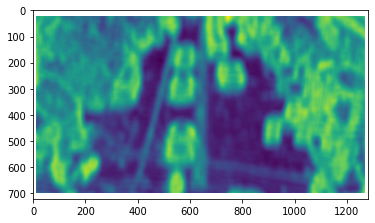

 56% (57 of 100) |#############          | Elapsed Time: 0:06:16 ETA:   0:04:56

1/1 [==============================] - 0s 229ms/step


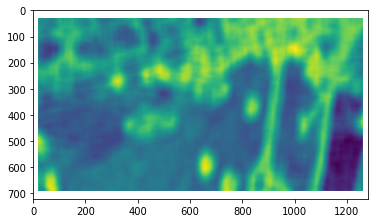

 57% (58 of 100) |#############          | Elapsed Time: 0:06:19 ETA:   0:02:15

1/1 [==============================] - 0s 287ms/step


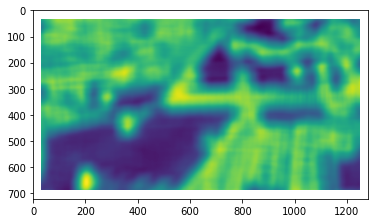

 59% (59 of 100) |#############          | Elapsed Time: 0:06:24 ETA:   0:03:37

1/1 [==============================] - 0s 324ms/step


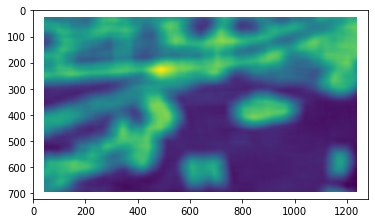

 60% (60 of 100) |#############          | Elapsed Time: 0:06:30 ETA:   0:03:39

1/1 [==============================] - 0s 243ms/step


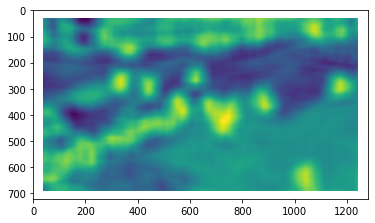

 61% (61 of 100) |##############         | Elapsed Time: 0:06:35 ETA:   0:03:35

1/1 [==============================] - 0s 290ms/step


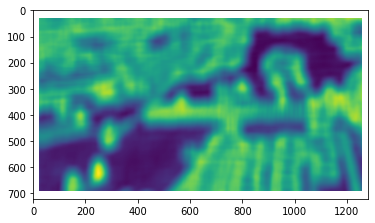

 62% (62 of 100) |##############         | Elapsed Time: 0:06:39 ETA:   0:02:18

1/1 [==============================] - 0s 323ms/step


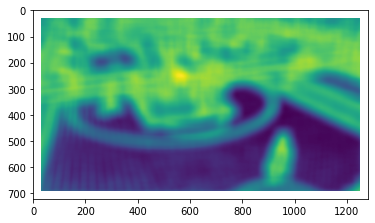

 63% (63 of 100) |##############         | Elapsed Time: 0:06:44 ETA:   0:02:53

1/1 [==============================] - 0s 287ms/step


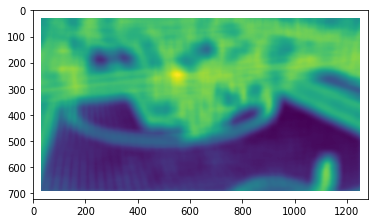

 64% (64 of 100) |##############         | Elapsed Time: 0:06:48 ETA:   0:02:40

1/1 [==============================] - 0s 243ms/step


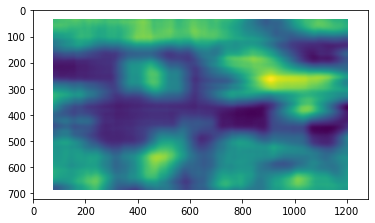

 65% (65 of 100) |##############         | Elapsed Time: 0:07:02 ETA:   0:07:45

1/1 [==============================] - 0s 253ms/step


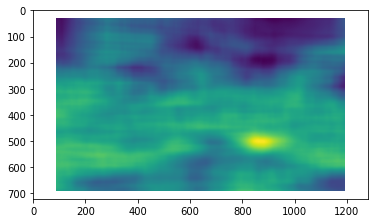

 66% (66 of 100) |###############        | Elapsed Time: 0:07:17 ETA:   0:08:28

1/1 [==============================] - 2s 2s/step


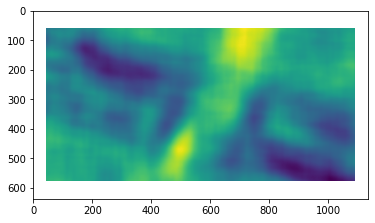

 67% (67 of 100) |###############        | Elapsed Time: 0:07:31 ETA:   0:07:49

1/1 [==============================] - 0s 305ms/step


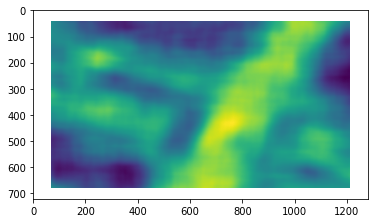

 68% (68 of 100) |###############        | Elapsed Time: 0:07:45 ETA:   0:07:37

1/1 [==============================] - 0s 317ms/step


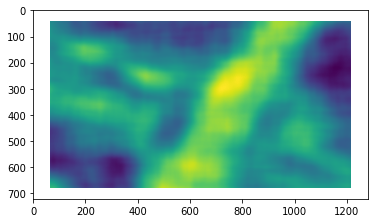

 69% (69 of 100) |###############        | Elapsed Time: 0:08:00 ETA:   0:07:32

1/1 [==============================] - 0s 239ms/step


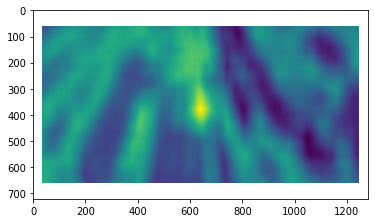

 70% (70 of 100) |################       | Elapsed Time: 0:08:11 ETA:   0:05:25

1/1 [==============================] - 2s 2s/step


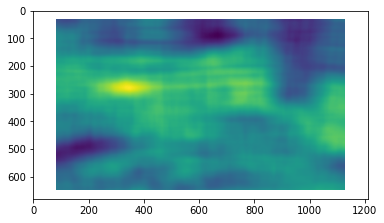

 71% (71 of 100) |################       | Elapsed Time: 0:08:26 ETA:   0:07:40

1/1 [==============================] - 2s 2s/step


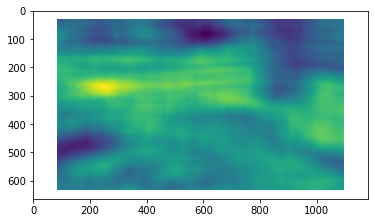

 72% (72 of 100) |################       | Elapsed Time: 0:08:41 ETA:   0:06:48

1/1 [==============================] - 2s 2s/step


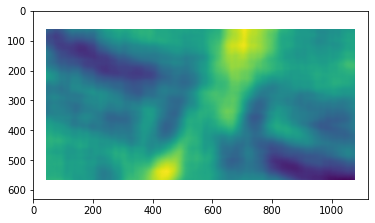

 73% (73 of 100) |################       | Elapsed Time: 0:08:55 ETA:   0:06:07

1/1 [==============================] - 0s 250ms/step


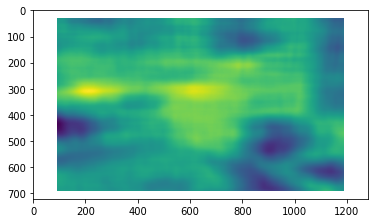

 74% (74 of 100) |#################      | Elapsed Time: 0:09:09 ETA:   0:06:20

1/1 [==============================] - 1s 1s/step


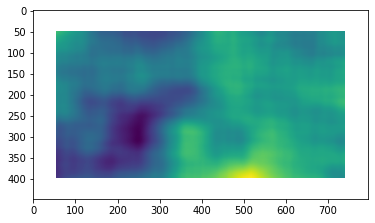

 75% (75 of 100) |#################      | Elapsed Time: 0:09:17 ETA:   0:03:23

1/1 [==============================] - 0s 307ms/step


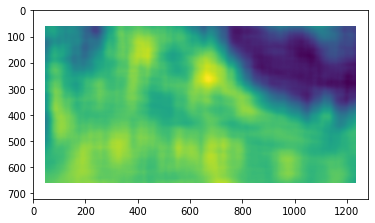

 76% (76 of 100) |#################      | Elapsed Time: 0:09:32 ETA:   0:05:51

1/1 [==============================] - 2s 2s/step


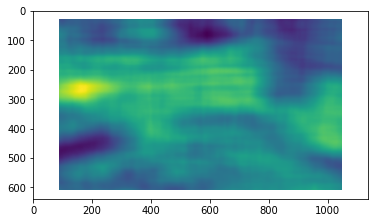

 77% (77 of 100) |#################      | Elapsed Time: 0:09:45 ETA:   0:05:05

1/1 [==============================] - 0s 264ms/step


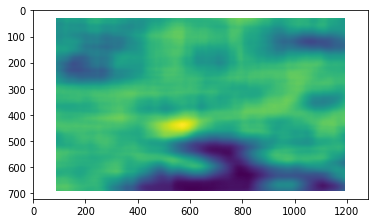

 78% (78 of 100) |#################      | Elapsed Time: 0:10:01 ETA:   0:05:51

1/1 [==============================] - 0s 238ms/step


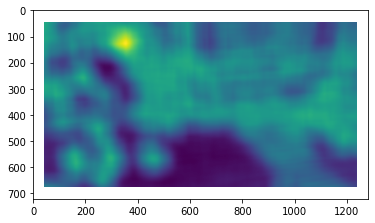

 79% (79 of 100) |##################     | Elapsed Time: 0:10:11 ETA:   0:03:23

1/1 [==============================] - 0s 317ms/step


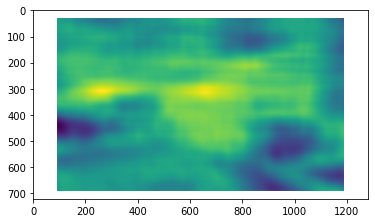

 80% (80 of 100) |##################     | Elapsed Time: 0:10:26 ETA:   0:04:52

1/1 [==============================] - 0s 332ms/step


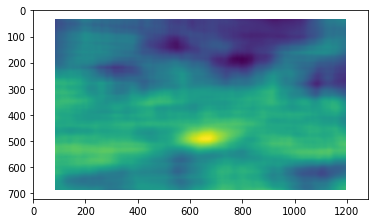

 81% (81 of 100) |##################     | Elapsed Time: 0:10:40 ETA:   0:04:41

1/1 [==============================] - 2s 2s/step


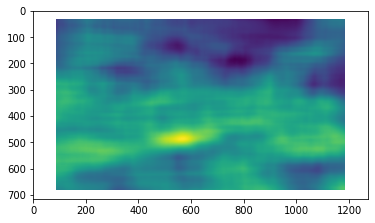

 82% (82 of 100) |##################     | Elapsed Time: 0:10:57 ETA:   0:04:52

1/1 [==============================] - 0s 335ms/step


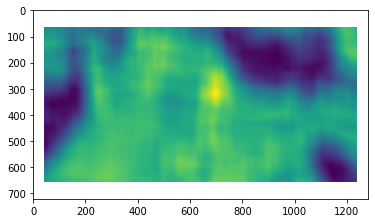

 83% (83 of 100) |###################    | Elapsed Time: 0:11:11 ETA:   0:04:04

1/1 [==============================] - 2s 2s/step


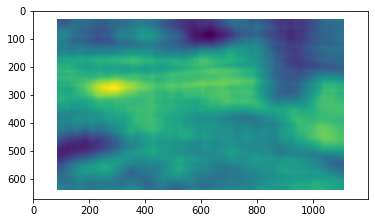

 84% (84 of 100) |###################    | Elapsed Time: 0:11:25 ETA:   0:03:50

1/1 [==============================] - 0s 311ms/step


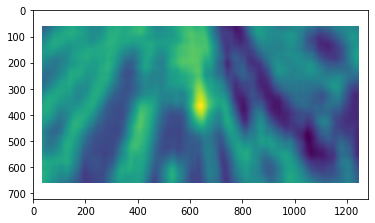

 85% (85 of 100) |###################    | Elapsed Time: 0:11:36 ETA:   0:02:45

1/1 [==============================] - 0s 231ms/step


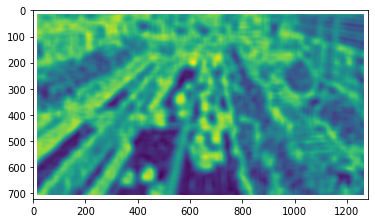

 86% (86 of 100) |###################    | Elapsed Time: 0:11:38 ETA:   0:01:29

1/1 [==============================] - 2s 2s/step


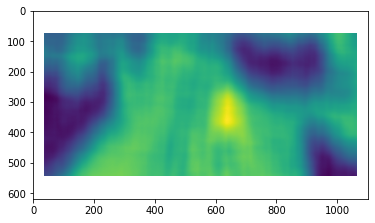

 87% (87 of 100) |####################   | Elapsed Time: 0:11:52 ETA:   0:02:53

1/1 [==============================] - 0s 256ms/step


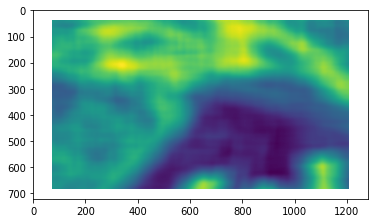

 88% (88 of 100) |####################   | Elapsed Time: 0:12:06 ETA:   0:02:57

1/1 [==============================] - 0s 332ms/step


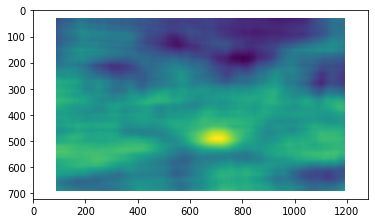

 89% (89 of 100) |####################   | Elapsed Time: 0:12:21 ETA:   0:02:39

1/1 [==============================] - 0s 284ms/step


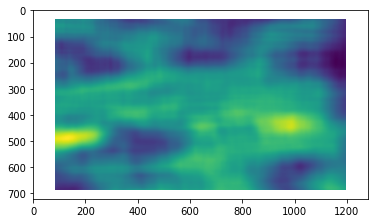

 90% (90 of 100) |####################   | Elapsed Time: 0:12:36 ETA:   0:02:26

1/1 [==============================] - 0s 311ms/step


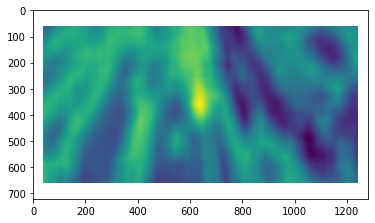

 91% (91 of 100) |####################   | Elapsed Time: 0:12:47 ETA:   0:01:46

1/1 [==============================] - 0s 310ms/step


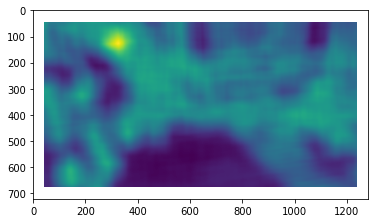

 92% (92 of 100) |#####################  | Elapsed Time: 0:12:57 ETA:   0:01:15

1/1 [==============================] - 0s 316ms/step


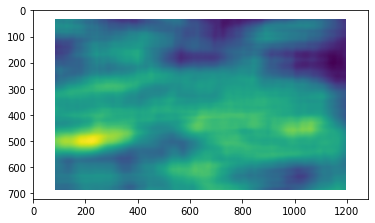

 93% (93 of 100) |#####################  | Elapsed Time: 0:13:11 ETA:   0:01:39

1/1 [==============================] - 0s 313ms/step


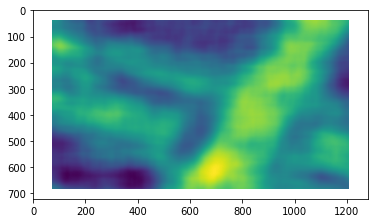

 94% (94 of 100) |#####################  | Elapsed Time: 0:13:26 ETA:   0:01:27

1/1 [==============================] - 0s 257ms/step


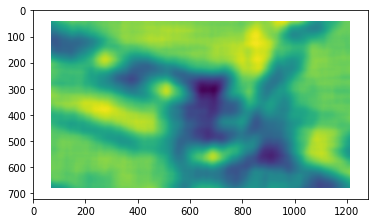

 95% (95 of 100) |#####################  | Elapsed Time: 0:13:40 ETA:   0:01:12

1/1 [==============================] - 0s 344ms/step


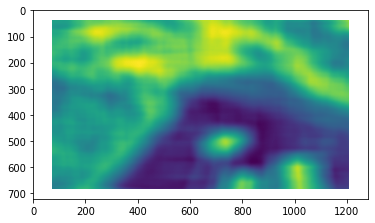

 96% (96 of 100) |###################### | Elapsed Time: 0:13:55 ETA:   0:00:59

1/1 [==============================] - 2s 2s/step


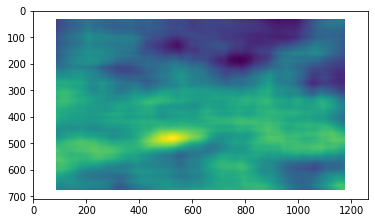

 97% (97 of 100) |###################### | Elapsed Time: 0:14:11 ETA:   0:00:48

1/1 [==============================] - 1s 1s/step


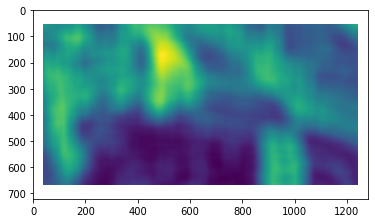

 98% (98 of 100) |###################### | Elapsed Time: 0:14:23 ETA:   0:00:24

1/1 [==============================] - 1s 680ms/step


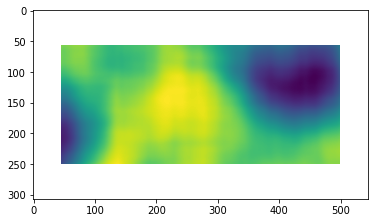

 99% (99 of 100) |###################### | Elapsed Time: 0:14:28 ETA:   0:00:04

1/1 [==============================] - 0s 309ms/step


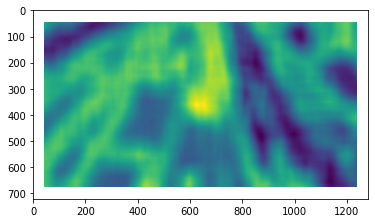

100% (100 of 100) |######################| Elapsed Time: 0:14:38 ETA:  00:00:00

1/1 [==============================] - 0s 319ms/step


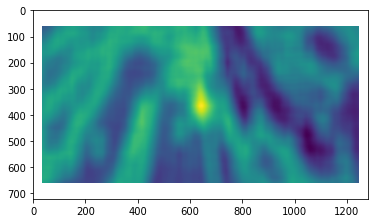

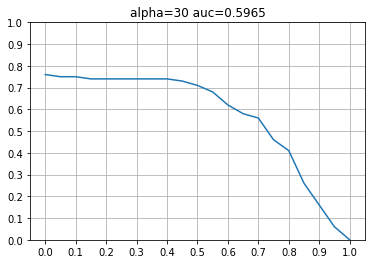

In [18]:
for k in [30]:
    score_list, gt_list, gray_list = model_eval( featex, alpha=k, backup=featex2)
    iou_score = all_sample_iou( score_list, gt_list )
    plot_success_curve( iou_score, title='alpha={} '.format(k) )

In [ ]:
gt_list

[(1147, 0, 31, 37)]